# Neural Networks

### CISC 351 - Data Analytics
### Marshall Ruse, 1006 6247

This notebook carries out the trial-and-error testing of the neural networks, implemented with the Keras API for Tensorflow, predicting default for Home Credit Default Challenge.  Note that although only 11 models are shown, more were tested, with sometimes subtle tweaks being made to the same models, replacing them rather than adding and entirely new one.   This was done randomly in the midst of development, and I regret that I was lazy at times and didn't create a whole new instance of a model each time to show progress during developpment, but it is what it is.

In [0]:
!pip install -q tensorflow==2.0.0a0

    100% |████████████████████████████████| 79.9MB 548kB/s 
    100% |████████████████████████████████| 419kB 14.4MB/s 
    100% |████████████████████████████████| 3.0MB 10.1MB/s 
    100% |████████████████████████████████| 61kB 19.3MB/s 


In [0]:
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [0]:
tf.__version__

'2.0.0-alpha0'

In [0]:
tf.executing_eagerly()

True

In [0]:
pd.set_option('display.width', 2000)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
appTrain = pd.read_csv('/content/drive/My Drive/CISC351/dataSet/preparedDataSet/application_train_prepared.csv', index_col='SK_ID_CURR')
appTest = pd.read_csv('/content/drive/My Drive/CISC351/dataSet/preparedDataSet/application_test_from_train_prepared.csv', index_col='SK_ID_CURR')
testingLabels = pd.read_csv('/content/drive/My Drive/CISC351/dataSet/preparedDataSet/testing_labels.csv', names=['SK_ID_CURR','TARGET'], index_col='SK_ID_CURR')

Process the data again to make it a bit more compatible with TF. For instance, change bool-type to integer 1,0 so TF can just use numeric feature columns. Also, normalize the floating point columns.

In [0]:
for col in appTrain:
  
  if appTrain[col].dtype == 'bool':
    appTrain[col] = appTrain[col].astype(int)
    
  if appTrain[col].dtype == 'float64':
    if appTrain[col].std() != 0:
      appTrain[col] = (appTrain[col] - appTrain[col].mean()) / appTrain[col].std()
    else:
      appTrain[col] = (appTrain[col] - appTrain[col].mean())
    
for col in appTest:
  
  if appTest[col].dtype == 'bool':
    appTest[col] = appTest[col].astype(int)
    
  if appTest[col].dtype == 'float64':
    if appTest[col].std() != 0:
      appTest[col] = (appTest[col] - appTest[col].mean()) / appTrain[col].std()
    else:
      appTest[col] = (appTest[col] - appTest[col].mean())



Tensorflow name_scope also doesn't like column names with spaces, so have to remove those

In [0]:
appTrain.columns = appTrain.columns.str.replace(" ","_")
appTrain.columns = appTrain.columns.str.replace(":","_")

appTest.columns = appTest.columns.str.replace(" ","_")
appTest.columns = appTest.columns.str.replace(":","_")



ORGANIZATION_TYPE_Industry__type_1 causes an error in testing of the NN for some reason (possibly related to being all zeroes?). Drop it, it doesn't contain that many values proportionally anyways.

In [0]:
appTrain.drop("ORGANIZATION_TYPE_Industry__type_1",axis=1,inplace=True)
appTest.drop("ORGANIZATION_TYPE_Industry__type_1",axis=1,inplace=True)

There are a couple rows with some missing values that made it through in appTest. Just drop them, they make up a very small percentage of the testing data.

In [0]:
appTest.dropna(axis=0, inplace=True)

Split appTrain into training and validation sets

In [0]:
appTrainTrain, appTrainVal = train_test_split(appTrain, test_size=0.2)
print(len(appTrainTrain), 'train examples')
print(len(appTrainVal), 'validation examples')


24601 train examples
6151 validation examples


Upsample the rarer class with SMOTE

In [0]:
def SMOTEUpSample(trainDF):
  
  trainDFCols = list(trainDF.columns)
  trainDFCols.remove('TARGET')
  sm = SMOTE(random_state=12, ratio=1.0)
  x_train_res, y_train_res = sm.fit_sample(trainDF.drop('TARGET', axis=1), trainDF['TARGET'])
  
  upSampDF = pd.DataFrame(x_train_res, columns=trainDFCols)
  upSampDF['TARGET'] = pd.Series(y_train_res)
  
  return upSampDF
  

In [0]:
appTrainTrainUpSamp = SMOTEUpSample(appTrainTrain)

A function to convert from a Panda's dataframe to a Tensforflow dataset.

In [0]:
def df_to_dataset(df, shuffle=True, batch_size=32):
  df = df.copy()
  labels = df.pop('TARGET')
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  if batch_size != None:
    ds = ds.batch(batch_size)
  return ds

df_to_dataset() expects the testing labels to be affixed to the testing set

In [0]:
appTest['TARGET'] = testingLabels

In [0]:
appTest.dropna(axis=0, inplace=True)

Testing with a small batch size

In [0]:
batch_size = 5 # A small batch sized is used for demonstration purposes
appTrainTrain_ds = df_to_dataset(appTrainTrain, batch_size=batch_size)
appTrainVal_ds = df_to_dataset(appTrainVal, shuffle=False, batch_size=batch_size)
appTest_ds = df_to_dataset(appTest, shuffle=False, batch_size=batch_size)

Examine the results of the input pipeline

In [0]:
for feature_batch, label_batch in appTrainTrain_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of AMT_GOODS_PRICE:', feature_batch['AMT_GOODS_PRICE'])
  print('A batch of TARGETS:', label_batch )

Every feature: ['FLAG_DOCUMENT_3', 'FLOORSMIN_AVG', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 'FLOORSMAX_AVG', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_WORK_CITY', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'REGION_POPULATION_RELATIVE', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'DAYS_LAST_PHONE_CHANGE', 'AMT_ANNUITY', 'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Cleaning_staff', 'OCCUPATION_TYPE_Cooking_staff', 'OCCUPATION_TYPE_Core_staff', 'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_HR_staff', 'OCCUPATION_TYPE_High_skill_tech_staff', 'OCCUPATION_TYPE_IT_staff', 'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_Low-skill_Laborers', 'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Medicine_staff', 'OCCUPATION_TYPE_Private_service_staff', 'OCCUPATION_TYPE_Realty_agents', 'OCCUPATION_TYPE_Sales_staff', 'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Security_staff', 'OCCUPATION_TYPE_Waiters/barmen_staff'

Create a feature layer to act as the input layer for the neural networks.

In [0]:
numeric_cols_appTrain = [col for col in list(appTrainTrainUpSamp.columns) if col != 'TARGET']
feature_columns_appTrain = []
for header in numeric_cols_appTrain:
  feature_columns_appTrain.append(feature_column.numeric_column(header))

feature_layer_appTrain = tf.keras.layers.DenseFeatures(feature_columns_appTrain)

In [0]:
batch_size = 32
appTrainTrainUpSamp_ds = df_to_dataset(appTrainTrainUpSamp, batch_size=batch_size)
appTrainVal_ds = df_to_dataset(appTrainVal, shuffle=False, batch_size=batch_size)
appTest_ds = df_to_dataset(appTest, shuffle=True, batch_size=batch_size)

A function to plot the ROC Curve given the ground-truth testing data and the predictions corresponding to those.

In [0]:
def makeROCCurve(y_true, y_pred):
  
  falsePosRate, truePosRate, _ = roc_curve(y_true, y_pred)
  roc_auc = auc(falsePosRate, truePosRate)
  
  fig, ax = plt.subplots(figsize=(10,10))
  lw = 2
  ax.plot(falsePosRate, truePosRate, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  
  ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic example')
  ax.legend(loc="lower right")
  plt.show()
  

Before building the model, we'll have to upweight our True values for our TARGET class, as they only account for about 8% of the model

In [0]:
appTrainTrain['TARGET'].sum() / appTrainTrain.shape[0]

0.07938701678793544

## Model 1


In [0]:
model1 = tf.keras.Sequential([
  feature_layer_appTrain,
  layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.001)),
  layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.001)),
  layers.Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(), metrics.Precision(), metrics.Recall()])

# Before fitting the model, remember to upweight the TARGET == 1 class, as it accounts 
# for only about 8% of the values in the training set
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(appTrainTrainUpSamp['TARGET']),
                                                 appTrainTrainUpSamp['TARGET'])

model1.fit(appTrainTrainUpSamp_ds, 
          validation_data=appTrainVal_ds, 
          epochs=5,
          class_weight=class_weights)

Epoch 1/5


W0409 18:05:57.003074 139996270909312 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


1415/1415 [==============================] - 134s 95ms/step - loss: 8.0787 - binary_accuracy: 0.4990 - precision: 0.5996 - recall: 0.0015 - val_loss: 1.4946 - val_binary_accuracy: 0.9189 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
1415/1415 [==============================] - 129s 91ms/step - loss: 7.9177 - binary_accuracy: 0.4987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4094 - val_binary_accuracy: 0.9189 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
1415/1415 [==============================] - 131s 93ms/step - loss: 7.8379 - binary_accuracy: 0.4987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3356 - val_binary_accuracy: 0.9189 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
1415/1415 [==============================] - 132s 94ms/step - loss: 7.7731 - binary_accuracy: 0.4987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.2819 - val_binary_accuracy: 0.9189 - val_precision: 0.0000e+00 - val_recal

In [0]:
test_scores = model1.evaluate(appTest_ds)
print("Accuracy: ", test_scores[1])
print("Precision: ", test_scores[2], " Recall: ", test_scores[3])

153/153 [==============================] - 11s 75ms/step - loss: 1.2665 - binary_accuracy: 0.9181 - precision: 0.0000e+00 - recall: 0.0000e+00
Accuracy:  0.918053
Precision:  0.0  Recall:  0.0


In [0]:
#test_scores = model.evaluate(appTest_ds)
#print("Accuracy: ", test_scores[1])
appTest_ds = df_to_dataset(appTest, shuffle=False, batch_size=(appTest.shape[0]))
y_pred = model1.predict_proba(appTest_ds, batch_size=None)

In [0]:
y_pred

array([[0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       ...,
       [0.000000e+00],
       [0.000000e+00],
       [4.175091e-34]], dtype=float32)

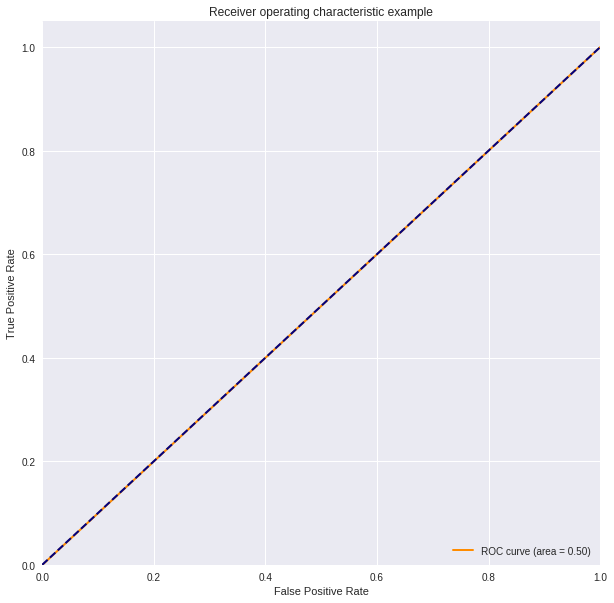

In [0]:
makeROCCurve(np.array(appTest['TARGET']), y_pred)

## Model 2

This is just  reducing the number of hidden nodes

In [0]:
model2 = tf.keras.Sequential([
  feature_layer_appTrain,
  layers.Dense(11, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(), metrics.Precision(), metrics.Recall()])

# Before fitting the model, remember to upweight the TARGET == 1 class, as it accounts 
# for only about 8% of the values in the training set
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(appTrainTrainUpSamp['TARGET']),
                                                 appTrainTrainUpSamp['TARGET'])

model2.fit(appTrainTrainUpSamp_ds, 
          validation_data=appTrainVal_ds, 
          epochs=5,
          class_weight=class_weights)

Epoch 1/5
1415/1415 [==============================] - 125s 89ms/step - loss: 7.2646 - binary_accuracy: 0.5242 - precision_1: 0.5152 - recall_1: 0.8655 - val_loss: 11.6296 - val_binary_accuracy: 0.2414 - val_precision_1: 0.0869 - val_recall_1: 0.8778
Epoch 2/5
1415/1415 [==============================] - 124s 87ms/step - loss: 7.2646 - binary_accuracy: 0.5242 - precision_1: 0.5152 - recall_1: 0.8655 - val_loss: 11.6296 - val_binary_accuracy: 0.2414 - val_precision_1: 0.0869 - val_recall_1: 0.8778
Epoch 3/5
1415/1415 [==============================] - 123s 87ms/step - loss: 7.2646 - binary_accuracy: 0.5242 - precision_1: 0.5152 - recall_1: 0.8655 - val_loss: 11.6296 - val_binary_accuracy: 0.2414 - val_precision_1: 0.0869 - val_recall_1: 0.8778
Epoch 4/5
1415/1415 [==============================] - 127s 90ms/step - loss: 7.2646 - binary_accuracy: 0.5242 - precision_1: 0.5152 - recall_1: 0.8655 - val_loss: 11.6296 - val_binary_accuracy: 0.2414 - val_precision_1: 0.0869 - val_recall_1: 0.8

In [0]:
test_scores = model2.evaluate(appTest_ds)
print("Accuracy: ", test_scores[1])
print("Precision: ", test_scores[2], " Recall: ", test_scores[3])

1/1 [==============================] - 1s 532ms/step - loss: 11.7732 - binary_accuracy: 0.2321 - precision_1: 0.0808 - recall_1: 0.8070
Accuracy:  0.2320805
Precision:  0.080823295  Recall:  0.80701756


In [0]:
#test_scores = model.evaluate(appTest_ds)
#print("Accuracy: ", test_scores[1])
appTest_ds = df_to_dataset(appTest, shuffle=False, batch_size=(appTest.shape[0]))
y_pred = model2.predict_proba(appTest_ds, batch_size=None)

In [0]:
y_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

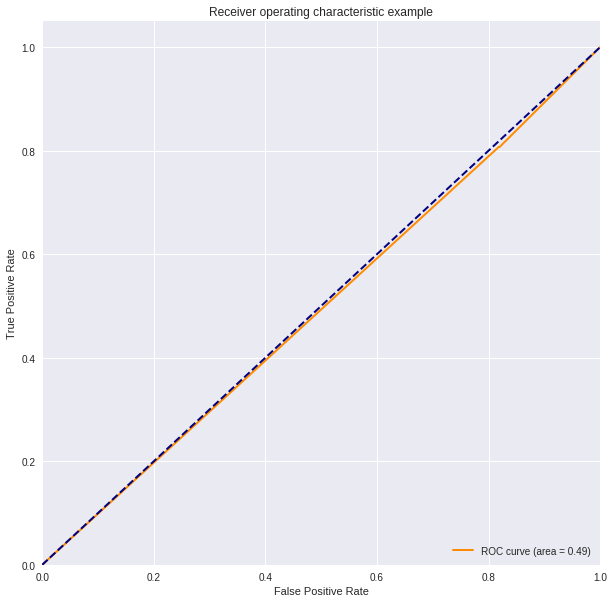

In [0]:
makeROCCurve(np.array(appTest['TARGET']), y_pred)

## Model 2b (with regularization)

In [0]:
model2b = tf.keras.Sequential([
  feature_layer_appTrain,
  layers.Dense(11, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
  layers.Dense(1, activation='sigmoid')
])

model2b.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(), metrics.Precision(), metrics.Recall()])

# Before fitting the model, remember to upweight the TARGET == 1 class, as it accounts 
# for only about 8% of the values in the training set
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(appTrainTrainUpSamp['TARGET']),
                                                 appTrainTrainUpSamp['TARGET'])

model2b.fit(appTrainTrainUpSamp_ds, 
          validation_data=appTrainVal_ds, 
          epochs=5,
          class_weight=class_weights)

Epoch 1/5
1415/1415 [==============================] - 124s 87ms/step - loss: 8.2513 - binary_accuracy: 0.4758 - precision_2: 0.4272 - recall_2: 0.1345 - val_loss: 3.8470 - val_binary_accuracy: 0.7586 - val_precision_2: 0.0551 - val_recall_2: 0.1222
Epoch 2/5
1415/1415 [==============================] - 127s 90ms/step - loss: 8.2496 - binary_accuracy: 0.4758 - precision_2: 0.4272 - recall_2: 0.1345 - val_loss: 3.8453 - val_binary_accuracy: 0.7586 - val_precision_2: 0.0551 - val_recall_2: 0.1222
Epoch 3/5
1415/1415 [==============================] - 125s 89ms/step - loss: 8.2479 - binary_accuracy: 0.4758 - precision_2: 0.4272 - recall_2: 0.1345 - val_loss: 3.8436 - val_binary_accuracy: 0.7586 - val_precision_2: 0.0551 - val_recall_2: 0.1222
Epoch 4/5
1415/1415 [==============================] - 127s 90ms/step - loss: 8.2462 - binary_accuracy: 0.4758 - precision_2: 0.4272 - recall_2: 0.1345 - val_loss: 3.8419 - val_binary_accuracy: 0.7586 - val_precision_2: 0.0551 - val_recall_2: 0.1222


In [0]:
test_scores = model2b.evaluate(appTest_ds)
print("Accuracy: ", test_scores[1])
print("Precision: ", test_scores[2], " Recall: ", test_scores[3])

1/1 [==============================] - 1s 552ms/step - loss: 3.6879 - binary_accuracy: 0.7683 - precision_2: 0.0656 - recall_2: 0.1378
Accuracy:  0.7683303
Precision:  0.06555423  Recall:  0.1378446


In [0]:
#test_scores = model.evaluate(appTest_ds)
#print("Accuracy: ", test_scores[1])
appTest_ds = df_to_dataset(appTest, shuffle=False, batch_size=(appTest.shape[0]))
y_pred = model2b.predict_proba(appTest_ds, batch_size=None)

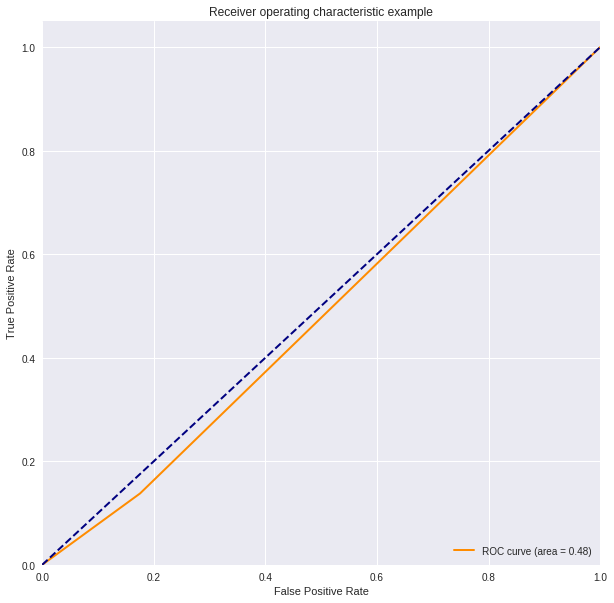

In [0]:
makeROCCurve(np.array(appTest['TARGET']), y_pred)

## FeatureMatrix


In [0]:
featureMatrix = pd.read_csv('/content/drive/My Drive/CISC351/dataSet/preparedDataSet/featureMatrix_prepared_normalized.csv',index_col='row ID')

In [0]:
featureMatrix.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CODE_GENDER_F,CODE_GENDER_M,COUNT(POSCash),COUNT(bureau),COUNT(bureauBalance),COUNT(creditCard),...,Loan amount / total income,Annuity amount / total income,Total debt / total income,Loan / total goods price,Total external credit limits,Current yearly payment pre,Growth in loan size (sparse) (0 if microfinance) over previous loan,Important Income - yearly credit payments (free cash flow),Years to pay back loan,TARGET
row ID,,,,,,,,,,,,,,,,,,,,,
100002,0.088480,0.090287,0.076404,0.001512,0.0,True,0.077551,0.068966,0.074728,0.000000,...,0.023640,0.064910,0.018721,0.255939,0.004030,0.005210,0.011038,0.180240,0.226870,1.0
100003,0.131445,0.311736,0.270787,0.002089,1.0,False,0.114286,0.034483,0.000000,0.000000,...,0.056483,0.070368,0.025528,0.251746,0.004740,0.006206,0.020073,0.182692,0.759361,0.0
100004,0.018353,0.022472,0.022472,0.000358,0.0,True,0.016327,0.017241,0.000000,0.000000,...,0.023547,0.053193,0.014303,0.205607,0.000881,0.005458,0.064731,0.184522,0.322173,0.0
100006,0.107958,0.066837,0.062921,0.000935,1.0,False,0.085714,0.000000,0.000000,0.058252,...,0.027278,0.117114,0.016171,0.222386,0.000681,0.005312,0.005455,0.184566,0.067220,0.0
100007,0.077404,0.116854,0.116854,0.000819,0.0,True,0.269388,0.008621,0.000000,0.000000,...,0.049774,0.095823,0.028895,0.205607,0.002182,0.005658,0.000982,0.184607,0.415395,0.0


The data has already been normalized. Just convert the bools to ints. I'm fairly certain Tensorflow sees them as ints anyways, but just to be on the safe side.

In [0]:
for col in featureMatrix:
  
  if featureMatrix[col].dtype == 'bool':
    featureMatrix[col] = featureMatrix[col].astype(int)

Remove any column names with symbols that TF doesn't like:

In [0]:
featureMatrix.columns = featureMatrix.columns.str.replace(" ","_")
featureMatrix.columns = featureMatrix.columns.str.replace(":","_")
featureMatrix.columns = featureMatrix.columns.str.replace("(","_")
featureMatrix.columns = featureMatrix.columns.str.replace(")","_")
featureMatrix.columns = featureMatrix.columns.str.replace("+","_")
featureMatrix.columns = featureMatrix.columns.str.replace(",","_")
featureMatrix.columns = featureMatrix.columns.str.replace(".","_")



Split up featureMatrix into its two previously concatenated parts

In [0]:
featMatTrain = featureMatrix[featureMatrix['TARGET'].notnull()]
featMatTest = featureMatrix[featureMatrix['TARGET'].isnull()]

In [0]:
featMatTest['TARGET'] = testingLabels

In [0]:
featMatTrainTrain, featMatTrainVal = train_test_split(featMatTrain, test_size=0.2)
print(len(featMatTrainTrain), 'train examples')
print(len(featMatTrainVal), 'validation examples')

24601 train examples
6151 validation examples


In [0]:
featMatTrainTrain.shape

(24601, 640)

In [0]:
featMatTrainTrain.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CODE_GENDER_F,CODE_GENDER_M,COUNT_POSCash_,COUNT_bureau_,COUNT_bureauBalance_,COUNT_creditCard_,...,Loan_amount_/_total_income,Annuity_amount_/_total_income,Total_debt_/_total_income,Loan_/_total_goods_price,Total_external_credit_limits,Current_yearly_payment_pre,Growth_in_loan_size__sparse___0_if_microfinance__over_previous_loan,Important_Income_-_yearly_credit_payments__free_cash_flow_,Years_to_pay_back_loan,TARGET
row ID,,,,,,,,,,,,,,,,,,,,,
104091,0.052740,0.030748,0.026966,0.002627,1.0,0,0.151020,0.060345,0.000000,0.116505,...,0.005903,0.024779,0.015858,0.237065,0.004889,0.006423,0.164719,0.279115,0.074736,0.0
117858,0.171651,0.111235,0.102247,0.001704,0.0,1,0.000000,0.025862,0.000000,0.000000,...,0.025671,0.108851,0.032975,0.230773,0.000838,0.005214,0.003591,0.244237,0.070787,0.0
102331,0.027143,0.033708,0.033708,0.000242,1.0,0,0.114286,0.025862,0.000000,0.000000,...,0.039283,0.088734,0.003720,0.205607,0.000105,0.005205,0.015666,0.098895,0.322173,0.0
132643,0.280365,0.163978,0.157303,0.001243,0.0,1,0.036735,0.103448,0.315897,0.000000,...,0.048375,0.230021,0.049483,0.218191,0.011331,0.005481,0.004056,0.162830,0.039573,0.0
127669,0.115131,0.257978,0.213483,0.000885,0.0,1,0.102041,0.043103,0.000000,0.000000,...,0.098471,0.130003,0.061014,0.268523,0.014996,0.008479,0.001953,0.040728,0.704694,0.0


In [0]:
featMatCols = list(featMatTrainTrain.columns)
featMatCols.remove('TARGET')
featMatIndex = featMatTrainTrain.index
sm = SMOTE(random_state=12, ratio=1.0)
x_train_res, y_train_res = sm.fit_sample(featMatTrainTrain.drop('TARGET', axis=1), featMatTrainTrain['TARGET'])

In [0]:
len(y_train_res)

45290

In [0]:
x_train_res = pd.DataFrame(x_train_res, columns = featMatCols)

In [0]:
x_train_res['TARGET'] = pd.Series(y_train_res)

In [0]:
featMatTest['TARGET'] = testingLabels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
featMatTest.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CODE_GENDER_F,CODE_GENDER_M,COUNT_POSCash_,COUNT_bureau_,COUNT_bureauBalance_,COUNT_creditCard_,...,Loan_amount_/_total_income,Annuity_amount_/_total_income,Total_debt_/_total_income,Loan_/_total_goods_price,Total_external_credit_limits,Current_yearly_payment_pre,Growth_in_loan_size__sparse___0_if_microfinance__over_previous_loan,Important_Income_-_yearly_credit_payments__free_cash_flow_,Years_to_pay_back_loan,TARGET
row ID,,,,,,,,,,,,,,,,,,,,,
157878,0.148902,0.224719,0.224719,0.001897,0.0,1,0.0,0.025862,0.103261,0.00000,...,0.045005,0.086402,0.034011,0.205607,0.004030,0.005210,0.004749,0.174477,0.417150,0
157879,0.097463,0.123596,0.123596,0.001320,0.0,1,0.0,0.008621,0.000000,0.00000,...,0.035349,0.079849,0.034011,0.205607,0.004740,0.006206,0.048083,0.174477,0.322173,0
157880,0.054533,0.062464,0.048315,0.000742,1.0,0,0.0,0.034483,0.052310,0.31068,...,0.030908,0.075755,0.034011,0.281108,0.000881,0.005458,0.029606,0.174477,0.280037,0
157881,0.059438,0.063299,0.056180,0.000319,1.0,0,0.0,0.000000,0.000000,0.00000,...,0.055864,0.145994,0.034011,0.239163,0.000681,0.005312,0.005714,0.174477,0.249152,0
157882,0.086757,0.148584,0.101124,0.000358,1.0,0,0.0,0.094828,0.000000,0.00000,...,0.111857,0.191485,0.034011,0.339828,0.002182,0.005658,0.000787,0.174477,0.494115,0


In [0]:
batch_size = 32
x_train_res_ds = df_to_dataset(x_train_res, batch_size=batch_size)
featMatTrainVal_ds = df_to_dataset(featMatTrainVal, shuffle=False, batch_size=batch_size)
featMatTest_ds = df_to_dataset(featMatTest, shuffle=False, batch_size=batch_size)

## Model 3

Same as Model 2, but with the feature matrix

In [0]:
model3 = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(),metrics.Precision(), metrics.Recall()])

# Before fitting the model, remember to upweight the TARGET == 1 class, as it accounts 
# for only about 8% of the values in the training set
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(x_train_res['TARGET']),
                                                 x_train_res['TARGET'])

model3.fit(x_train_res_ds, 
          validation_data=featMatTrainVal_ds, 
          epochs=5,
          class_weight=class_weights)

Epoch 1/5
1416/1416 [==============================] - 169s 119ms/step - loss: 0.6879 - binary_accuracy: 0.5314 - precision_3: 0.5248 - recall_3: 0.6970 - val_loss: 0.6875 - val_binary_accuracy: 0.5276 - val_precision_3: 0.1001 - val_recall_3: 0.5906
Epoch 2/5
1416/1416 [==============================] - 167s 118ms/step - loss: 0.6763 - binary_accuracy: 0.5899 - precision_3: 0.5784 - recall_3: 0.6695 - val_loss: 0.6759 - val_binary_accuracy: 0.5770 - val_precision_3: 0.1156 - val_recall_3: 0.6201
Epoch 3/5
1416/1416 [==============================] - 168s 119ms/step - loss: 0.6662 - binary_accuracy: 0.6174 - precision_3: 0.6054 - recall_3: 0.6789 - val_loss: 0.6657 - val_binary_accuracy: 0.6058 - val_precision_3: 0.1228 - val_recall_3: 0.6142
Epoch 4/5
1416/1416 [==============================] - 167s 118ms/step - loss: 0.6565 - binary_accuracy: 0.6349 - precision_3: 0.6246 - recall_3: 0.6802 - val_loss: 0.6554 - val_binary_accuracy: 0.6266 - val_precision_3: 0.1284 - val_recall_3: 0.6

In [0]:
test_scores = model3.evaluate(featMatTest_ds)
print("Accuracy: ", test_scores[1])
print("Precision: ", test_scores[2], " Recall: ", test_scores[3])

153/153 [==============================] - 14s 91ms/step - loss: 0.6421 - binary_accuracy: 0.6498 - precision_3: 0.1322 - recall_3: 0.5890
Accuracy:  0.6497639
Precision:  0.13224536  Recall:  0.58897245


In [0]:
featMatTest_ds = df_to_dataset(featMatTest, shuffle=False, batch_size=(featMatTest.shape[0]))
y_pred = model3.predict_proba(featMatTest_ds, batch_size=None)

In [0]:
score = roc_auc_score(np.array(featMatTest['TARGET']), y_pred)

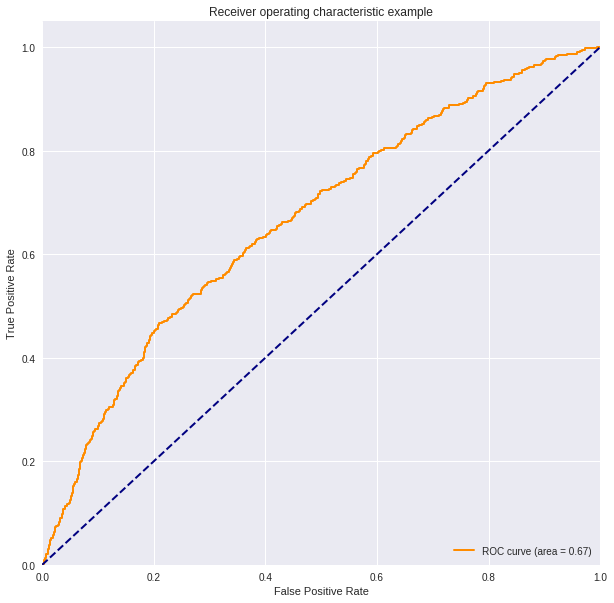

In [0]:
makeROCCurve(np.array(featMatTest['TARGET']), y_pred)

In [0]:
score


0.6663309660555683

In [0]:
y_pred

array([[0.42781395],
       [0.59308195],
       [0.44871482],
       ...,
       [0.39777666],
       [0.40534934],
       [0.65803677]], dtype=float32)

## Model 4

In [0]:
model4 = tf.keras.Sequential([
  feature_layer,
  layers.Dense(32, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model4.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(),metrics.Precision(), metrics.Recall()])

# Before fitting the model, remember to upweight the TARGET == 1 class, as it accounts 
# for only about 8% of the values in the training set
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(x_train_res['TARGET']),
                                                 x_train_res['TARGET'])

model4.fit(x_train_res_ds, 
          validation_data=featMatTrainVal_ds, 
          epochs=5,
          class_weight=class_weights)

Epoch 1/5
1416/1416 [==============================] - 169s 119ms/step - loss: 0.6901 - binary_accuracy: 0.5146 - precision_4: 0.5085 - recall_4: 0.9683 - val_loss: 0.6947 - val_binary_accuracy: 0.4884 - val_precision_4: 0.0991 - val_recall_4: 0.6417
Epoch 2/5
1416/1416 [==============================] - 167s 118ms/step - loss: 0.6825 - binary_accuracy: 0.5796 - precision_4: 0.5709 - recall_4: 0.6481 - val_loss: 0.6792 - val_binary_accuracy: 0.5775 - val_precision_4: 0.1112 - val_recall_4: 0.5886
Epoch 3/5
1416/1416 [==============================] - 168s 118ms/step - loss: 0.6759 - binary_accuracy: 0.5988 - precision_4: 0.5934 - recall_4: 0.6322 - val_loss: 0.6725 - val_binary_accuracy: 0.5864 - val_precision_4: 0.1156 - val_recall_4: 0.6024
Epoch 4/5
1416/1416 [==============================] - 168s 118ms/step - loss: 0.6690 - binary_accuracy: 0.6112 - precision_4: 0.6041 - recall_4: 0.6498 - val_loss: 0.6646 - val_binary_accuracy: 0.5958 - val_precision_4: 0.1205 - val_recall_4: 0.6

In [0]:
test_scores = model4.evaluate(featMatTest_ds)
print("Accuracy: ", test_scores[1])
print("Precision: ", test_scores[2], " Recall: ", test_scores[3])

1/1 [==============================] - 4s 4s/step - loss: 0.6531 - binary_accuracy: 0.6171 - precision_4: 0.1272 - recall_4: 0.6266
Accuracy:  0.61712176
Precision:  0.12716176  Recall:  0.6265664


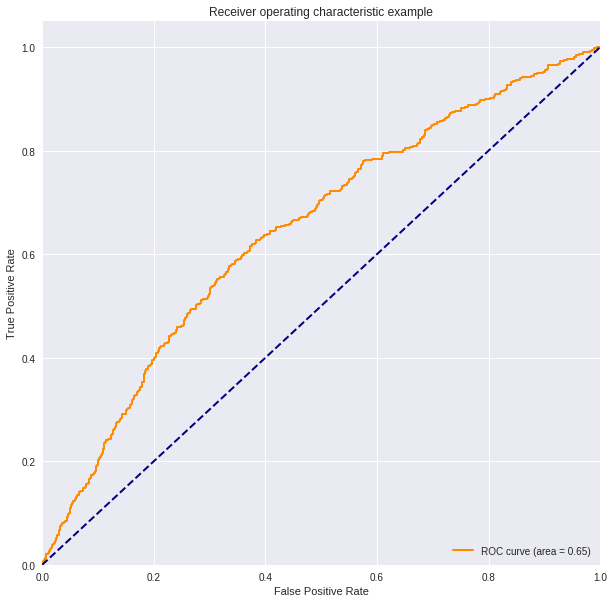

In [0]:
featMatTest_ds = df_to_dataset(featMatTest, shuffle=False, batch_size=(featMatTest.shape[0]))
y_pred4 = model4.predict_proba(featMatTest_ds, batch_size=None)
makeROCCurve(np.array(featMatTest['TARGET']), y_pred4)

## Model 5

In [0]:
featMatTrainUpSamp = SMOTEUpSample(featMatTrainTrain)

In [0]:
batch_size = 32
featMatTrainUpSamp_ds = df_to_dataset(featMatTrainUpSamp, batch_size=batch_size)
featMatTrainVal_ds = df_to_dataset(featMatTrainVal, shuffle=False, batch_size=batch_size)
featMatTest_ds = df_to_dataset(featMatTest, shuffle=False, batch_size=batch_size)

In [0]:
numeric_cols = [col for col in list(featMatTrainUpSamp.columns) if col != 'TARGET']
feature_columns = []
for header in numeric_cols:
  feature_columns.append(feature_column.numeric_column(header))

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

Model 3 performed slightly better, iterate on it - change the optimizer from sotchastic gradient descent to 'adam'

In [0]:
model5 = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(),metrics.Precision(), metrics.Recall()])

# Before fitting the model, remember to upweight the TARGET == 1 class, as it accounts 
# for only about 8% of the values in the training set
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(featMatTrainUpSamp['TARGET']),
                                                 featMatTrainUpSamp['TARGET'])

model5.fit(featMatTrainUpSamp_ds, 
          validation_data=featMatTrainVal_ds, 
          epochs=5,
          class_weight=class_weights)

Epoch 1/5
1416/1416 [==============================] - 171s 121ms/step - loss: 0.5349 - binary_accuracy: 0.6956 - precision_10: 0.6855 - recall_10: 0.7355 - val_loss: 0.7623 - val_binary_accuracy: 0.5674 - val_precision_10: 0.1287 - val_recall_10: 0.7343
Epoch 2/5
1416/1416 [==============================] - 170s 120ms/step - loss: 0.4200 - binary_accuracy: 0.7948 - precision_10: 0.7822 - recall_10: 0.8207 - val_loss: 0.7307 - val_binary_accuracy: 0.6123 - val_precision_10: 0.1248 - val_recall_10: 0.6142
Epoch 3/5
1416/1416 [==============================] - 169s 120ms/step - loss: 0.3496 - binary_accuracy: 0.8373 - precision_10: 0.8275 - recall_10: 0.8548 - val_loss: 0.6716 - val_binary_accuracy: 0.6659 - val_precision_10: 0.1265 - val_recall_10: 0.5157
Epoch 4/5
1416/1416 [==============================] - 168s 118ms/step - loss: 0.3058 - binary_accuracy: 0.8598 - precision_10: 0.8508 - recall_10: 0.8747 - val_loss: 0.6713 - val_binary_accuracy: 0.6866 - val_precision_10: 0.1247 - va

In [0]:
test_scores = model5.evaluate(featMatTest_ds)
print("Accuracy: ", test_scores[1])
print("Precision: ", test_scores[2], " Recall: ", test_scores[3])

1/1 [==============================] - 4s 4s/step - loss: 0.6240 - binary_accuracy: 0.7434 - precision_10: 0.1571 - recall_10: 0.4887
Accuracy:  0.7433792
Precision:  0.15713134  Recall:  0.48872182


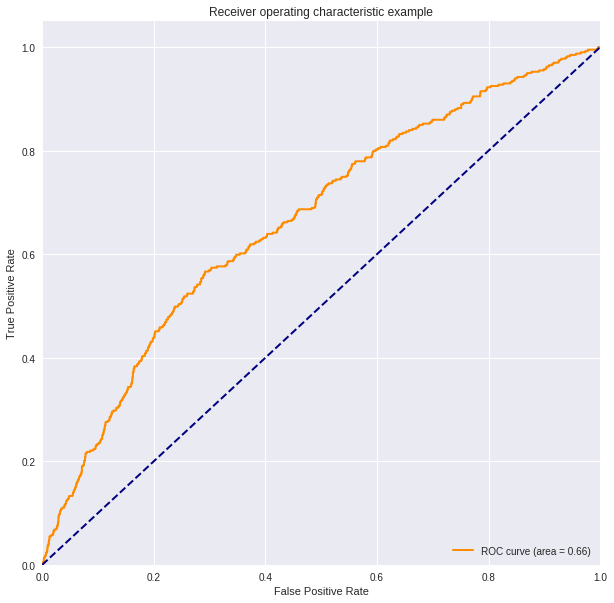

In [0]:
featMatTest_ds = df_to_dataset(featMatTest, shuffle=False, batch_size=(featMatTest.shape[0]))
y_pred5 = model5.predict_proba(featMatTest_ds, batch_size=None)
makeROCCurve(np.array(featMatTest['TARGET']), y_pred5)

## Model 6

In [0]:
model6 = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model6.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(),metrics.Precision(), metrics.Recall()])

# Before fitting the model, remember to upweight the TARGET == 1 class, as it accounts 
# for only about 8% of the values in the training set
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(featMatTrainUpSamp['TARGET']),
                                                 featMatTrainUpSamp['TARGET'])

model6.fit(featMatTrainUpSamp_ds, 
          validation_data=featMatTrainVal_ds, 
          epochs=5,
          class_weight=class_weights)

Epoch 1/5
1416/1416 [==============================] - 185s 130ms/step - loss: 0.5312 - binary_accuracy: 0.6883 - precision_11: 0.6785 - recall_11: 0.7314 - val_loss: 0.3600 - val_binary_accuracy: 0.8465 - val_precision_11: 0.2038 - val_recall_11: 0.2953
Epoch 2/5
1416/1416 [==============================] - 184s 130ms/step - loss: 0.4048 - binary_accuracy: 0.8000 - precision_11: 0.7857 - recall_11: 0.8287 - val_loss: 0.3617 - val_binary_accuracy: 0.8706 - val_precision_11: 0.1897 - val_recall_11: 0.1732
Epoch 3/5
1416/1416 [==============================] - 183s 130ms/step - loss: 0.3327 - binary_accuracy: 0.8449 - precision_11: 0.8360 - recall_11: 0.8608 - val_loss: 0.3885 - val_binary_accuracy: 0.8704 - val_precision_11: 0.1852 - val_recall_11: 0.1673
Epoch 4/5
1416/1416 [==============================] - 184s 130ms/step - loss: 0.2924 - binary_accuracy: 0.8678 - precision_11: 0.8605 - recall_11: 0.8800 - val_loss: 0.4155 - val_binary_accuracy: 0.8706 - val_precision_11: 0.1842 - va

In [0]:
test_scores = model6.evaluate(featMatTest_ds)
print("Accuracy: ", test_scores[1])
print("Precision: ", test_scores[2], " Recall: ", test_scores[3])

1/1 [==============================] - 4s 4s/step - loss: 0.4331 - binary_accuracy: 0.8608 - precision_11: 0.1837 - recall_11: 0.2030
Accuracy:  0.86080885
Precision:  0.18367347  Recall:  0.20300752


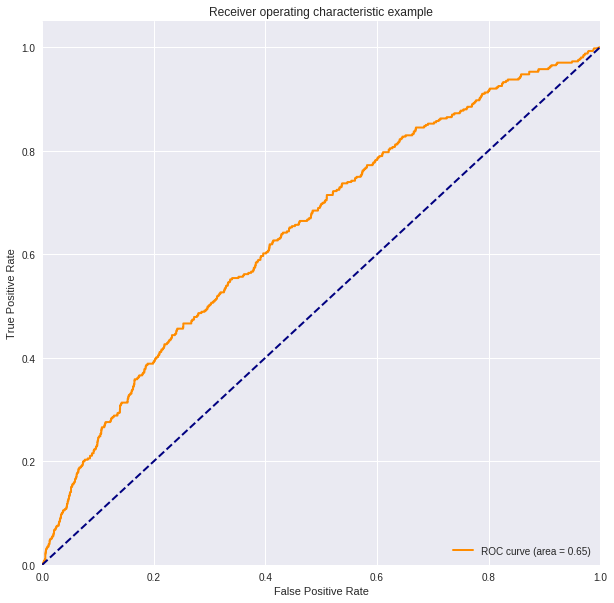

In [0]:
featMatTest_ds = df_to_dataset(featMatTest, shuffle=False, batch_size=(featMatTest.shape[0]))
y_pred6 = model6.predict_proba(featMatTest_ds, batch_size=None)
makeROCCurve(np.array(featMatTest['TARGET']), y_pred6)

## Model 7

In [0]:
model7 = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model7.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(),metrics.Precision(), metrics.Recall()])

# Before fitting the model, remember to upweight the TARGET == 1 class, as it accounts 
# for only about 8% of the values in the training set
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(featMatTrainUpSamp['TARGET']),
                                                 featMatTrainUpSamp['TARGET'])

model7.fit(featMatTrainUpSamp_ds, 
          validation_data=featMatTrainVal_ds, 
          epochs=5,
          class_weight=class_weights)

Epoch 1/5
1416/1416 [==============================] - 197s 139ms/step - loss: 0.5305 - binary_accuracy: 0.6890 - precision_12: 0.6780 - recall_12: 0.7338 - val_loss: 0.3588 - val_binary_accuracy: 0.8436 - val_precision_12: 0.1941 - val_recall_12: 0.2835
Epoch 2/5
1416/1416 [==============================] - 192s 136ms/step - loss: 0.4048 - binary_accuracy: 0.8002 - precision_12: 0.7852 - recall_12: 0.8303 - val_loss: 0.3506 - val_binary_accuracy: 0.8669 - val_precision_12: 0.2093 - val_recall_12: 0.2205
Epoch 3/5
1416/1416 [==============================] - 193s 136ms/step - loss: 0.3330 - binary_accuracy: 0.8424 - precision_12: 0.8331 - recall_12: 0.8590 - val_loss: 0.3804 - val_binary_accuracy: 0.8538 - val_precision_12: 0.1714 - val_recall_12: 0.2008
Epoch 4/5
1416/1416 [==============================] - 196s 139ms/step - loss: 0.2889 - binary_accuracy: 0.8694 - precision_12: 0.8609 - recall_12: 0.8833 - val_loss: 0.3916 - val_binary_accuracy: 0.8587 - val_precision_12: 0.1614 - va

In [0]:
test_scores = model7.evaluate(featMatTest_ds)
print("Accuracy: ", test_scores[1])
print("Precision: ", test_scores[2], " Recall: ", test_scores[3])

1/1 [==============================] - 4s 4s/step - loss: 0.4245 - binary_accuracy: 0.8425 - precision_12: 0.1783 - recall_12: 0.2556
Accuracy:  0.84253746
Precision:  0.17832167  Recall:  0.2556391


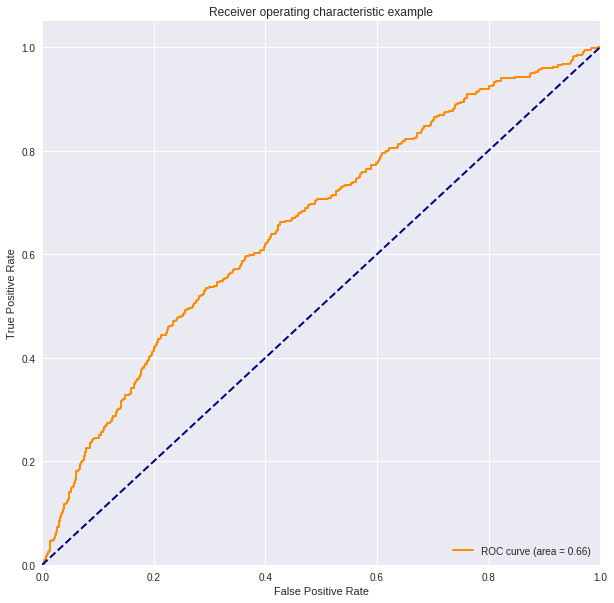

In [0]:
featMatTest_ds = df_to_dataset(featMatTest, shuffle=False, batch_size=(featMatTest.shape[0]))
y_pred7 = model7.predict_proba(featMatTest_ds, batch_size=None)
makeROCCurve(np.array(featMatTest['TARGET']), y_pred7)

## Model 8

In [0]:
model8 = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model8.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(),metrics.Precision(), metrics.Recall()])

# Before fitting the model, remember to upweight the TARGET == 1 class, as it accounts 
# for only about 8% of the values in the training set
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(featMatTrainUpSamp['TARGET']),
                                                 featMatTrainUpSamp['TARGET'])

model8.fit(featMatTrainUpSamp_ds, 
          validation_data=featMatTrainVal_ds, 
          epochs=5,
          class_weight=class_weights)

Epoch 1/5
1416/1416 [==============================] - 177s 125ms/step - loss: 0.5324 - binary_accuracy: 0.6876 - precision_13: 0.6762 - recall_13: 0.7377 - val_loss: 0.7002 - val_binary_accuracy: 0.6170 - val_precision_13: 0.1330 - val_recall_13: 0.6594
Epoch 2/5
1416/1416 [==============================] - 177s 125ms/step - loss: 0.4117 - binary_accuracy: 0.7971 - precision_13: 0.7840 - recall_13: 0.8239 - val_loss: 0.6819 - val_binary_accuracy: 0.6521 - val_precision_13: 0.1344 - val_recall_13: 0.5906
Epoch 3/5
1416/1416 [==============================] - 177s 125ms/step - loss: 0.3426 - binary_accuracy: 0.8423 - precision_13: 0.8314 - recall_13: 0.8613 - val_loss: 0.5982 - val_binary_accuracy: 0.7220 - val_precision_13: 0.1418 - val_recall_13: 0.4685
Epoch 4/5
1416/1416 [==============================] - 178s 125ms/step - loss: 0.2996 - binary_accuracy: 0.8638 - precision_13: 0.8561 - recall_13: 0.8768 - val_loss: 0.5500 - val_binary_accuracy: 0.7708 - val_precision_13: 0.1515 - va

In [0]:
test_scores = model8.evaluate(featMatTest_ds)
print("Accuracy: ", test_scores[1])
print("Precision: ", test_scores[2], " Recall: ", test_scores[3])

1/1 [==============================] - 4s 4s/step - loss: 0.6161 - binary_accuracy: 0.7413 - precision_13: 0.1468 - recall_13: 0.4486
Accuracy:  0.7413262
Precision:  0.14684168  Recall:  0.44862154


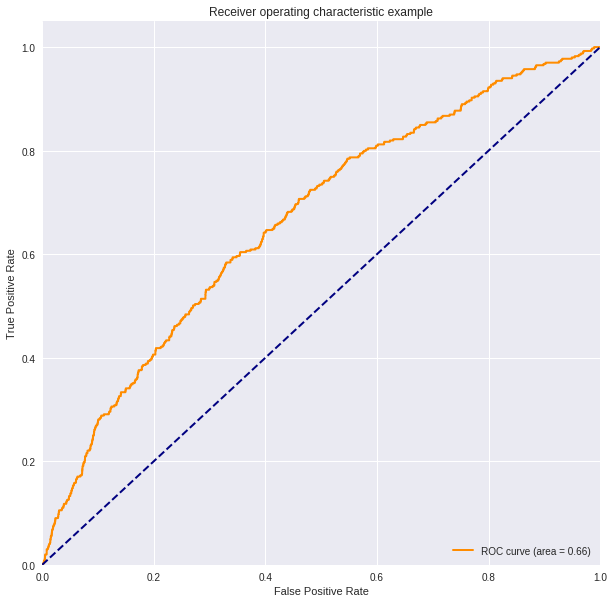

In [0]:
featMatTest_ds = df_to_dataset(featMatTest, shuffle=False, batch_size=(featMatTest.shape[0]))
y_pred8 = model8.predict_proba(featMatTest_ds, batch_size=None)
makeROCCurve(np.array(featMatTest['TARGET']), y_pred8)

## Model 9

In [0]:
model9 = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model9.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(),metrics.Precision(), metrics.Recall()])

# Before fitting the model, remember to upweight the TARGET == 1 class, as it accounts 
# for only about 8% of the values in the training set
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(featMatTrainUpSamp['TARGET']),
                                                 featMatTrainUpSamp['TARGET'])

model9.fit(featMatTrainUpSamp_ds, 
          validation_data=featMatTrainVal_ds, 
          epochs=10,
          class_weight=class_weights)

Epoch 1/10
1416/1416 [==============================] - 180s 127ms/step - loss: 0.5402 - binary_accuracy: 0.6866 - precision_14: 0.6728 - recall_14: 0.7372 - val_loss: 0.6545 - val_binary_accuracy: 0.6350 - val_precision_14: 0.1395 - val_recall_14: 0.6614
Epoch 2/10
1416/1416 [==============================] - 178s 126ms/step - loss: 0.4240 - binary_accuracy: 0.7903 - precision_14: 0.7746 - recall_14: 0.8229 - val_loss: 0.5782 - val_binary_accuracy: 0.7080 - val_precision_14: 0.1410 - val_recall_14: 0.4980
Epoch 3/10
1416/1416 [==============================] - 178s 126ms/step - loss: 0.3525 - binary_accuracy: 0.8333 - precision_14: 0.8217 - recall_14: 0.8541 - val_loss: 0.5934 - val_binary_accuracy: 0.7181 - val_precision_14: 0.1342 - val_recall_14: 0.4429
Epoch 4/10
1416/1416 [==============================] - 178s 126ms/step - loss: 0.3101 - binary_accuracy: 0.8593 - precision_14: 0.8506 - recall_14: 0.8738 - val_loss: 0.5818 - val_binary_accuracy: 0.7474 - val_precision_14: 0.1363 

In [0]:
test_scores = model9.evaluate(featMatTest_ds)
print("Accuracy: ", test_scores[1])
print("Precision: ", test_scores[2], " Recall: ", test_scores[3])

1/1 [==============================] - 4s 4s/step - loss: 0.6342 - binary_accuracy: 0.7707 - precision_14: 0.1535 - recall_14: 0.3985
Accuracy:  0.77068365
Precision:  0.1534749  Recall:  0.39849624


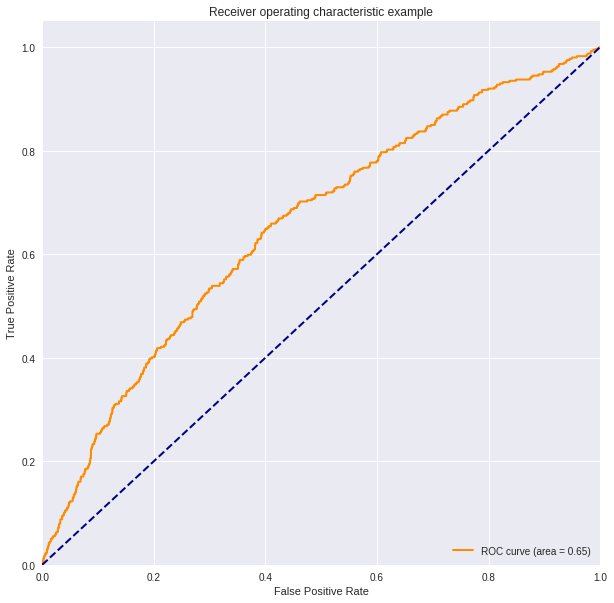

In [0]:
featMatTest_ds = df_to_dataset(featMatTest, shuffle=False, batch_size=(featMatTest.shape[0]))
y_pred9 = model9.predict_proba(featMatTest_ds, batch_size=None)
makeROCCurve(np.array(featMatTest['TARGET']), y_pred9)

## Model 10

In [0]:
model10 = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
  layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
  layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
  layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
  layers.Dense(1, activation='sigmoid')
])

model10.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(),metrics.Precision(), metrics.Recall()])

# Before fitting the model, remember to upweight the TARGET == 1 class, as it accounts 
# for only about 8% of the values in the training set
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(featMatTrainUpSamp['TARGET']),
                                                 featMatTrainUpSamp['TARGET'])

model10.fit(featMatTrainUpSamp_ds, 
          validation_data=featMatTrainVal_ds, 
          epochs=5,
          class_weight=class_weights)

Epoch 1/5


W0403 15:28:32.026602 140380155484032 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


1414/1414 [==============================] - 525s 372ms/step - loss: 0.9210 - binary_accuracy: 0.6695 - precision: 0.6607 - recall: 0.7021 - val_loss: 0.8095 - val_binary_accuracy: 0.5589 - val_precision: 0.1270 - val_recall: 0.7900
Epoch 2/5
1414/1414 [==============================] - 523s 370ms/step - loss: 0.6544 - binary_accuracy: 0.7084 - precision: 0.6974 - recall: 0.7372 - val_loss: 0.7854 - val_binary_accuracy: 0.5607 - val_precision: 0.1277 - val_recall: 0.7921
Epoch 3/5
1414/1414 [==============================] - 521s 369ms/step - loss: 0.6249 - binary_accuracy: 0.7158 - precision: 0.7047 - recall: 0.7437 - val_loss: 0.7089 - val_binary_accuracy: 0.6210 - val_precision: 0.1392 - val_recall: 0.7422
Epoch 4/5
1414/1414 [==============================] - 521s 368ms/step - loss: 0.6093 - binary_accuracy: 0.7229 - precision: 0.7106 - recall: 0.7528 - val_loss: 0.6515 - val_binary_accuracy: 0.6641 - val_precision: 0.1476 - val_recall: 0.6902
Epoch 5/5
1414/1414 [=================

In [0]:
featMatTest.dropna(axis=0, inplace=True)

In [0]:
featMatTest_ds = df_to_dataset(featMatTest, shuffle=True, batch_size=(featMatTest.shape[0]))


In [0]:
test_scores = model10.evaluate(featMatTest_ds)
print("Accuracy: ", test_scores[1])
print("Precision: ", test_scores[2], " Recall: ", test_scores[3])

1/1 [==============================] - 4s 4s/step - loss: 0.5933 - binary_accuracy: 0.7088 - precision: 0.1650 - recall: 0.6291
Accuracy:  0.70876974
Precision:  0.16502301  Recall:  0.62907267


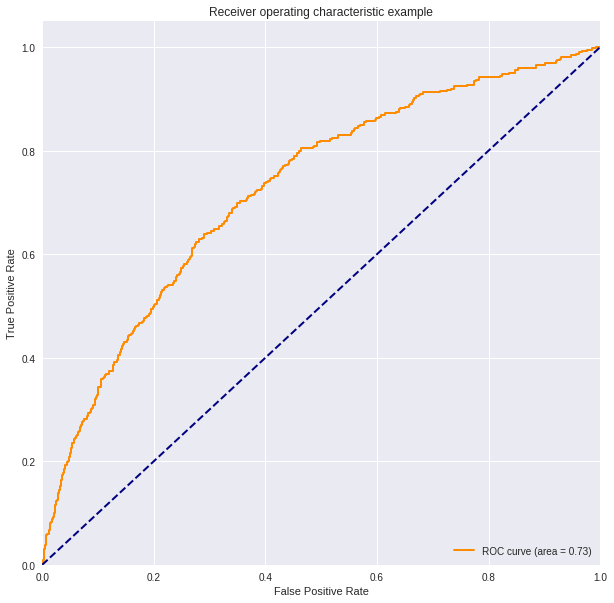

In [0]:
featMatTest_ds = df_to_dataset(featMatTest, shuffle=False, batch_size=(featMatTest.shape[0]))
y_pred10 = model10.predict_proba(featMatTest_ds, batch_size=None)
makeROCCurve(np.array(featMatTest['TARGET']), y_pred10)

This is the best model so far. See if it can be improved upon by only training on the most important features, as determined by a random forest model.

## featureMatrixMostImportant

In [0]:
featMatMostImpTrain = pd.read_csv('/content/drive/My Drive/CISC351/dataSet/preparedDataSet/featureMatrix_mostImportant_prepared_TRAIN.csv',index_col='SK_ID_CURR')
featMatMostImpTest = pd.read_csv('/content/drive/My Drive/CISC351/dataSet/preparedDataSet/featureMatrix_mostImportant_prepared_TEST.csv',index_col='SK_ID_CURR')

Carry out all of the same pre-processing as before.

In [0]:
for col in featMatMostImpTrain:
  
  if featMatMostImpTrain[col].dtype == 'bool':
    featMatMostImpTrain[col] = featMatMostImpTrain[col].astype(int)
    
  if (featMatMostImpTrain[col].dtype == 'float64') and (col != 'TARGET'):
    featMatMostImpTrain[col] = (featMatMostImpTrain[col] - featMatMostImpTrain[col].mean()) / featMatMostImpTrain[col].std()
    
for col in featMatMostImpTest:
  
  if featMatMostImpTest[col].dtype == 'bool':
    featMatMostImpTest[col] = featMatMostImpTest[col].astype(int)
    
  if featMatMostImpTest[col].dtype == 'float64' and (col != 'TARGET'):
    featMatMostImpTest[col] = (featMatMostImpTest[col] - featMatMostImpTest[col].mean()) / featMatMostImpTest[col].std()


In [0]:
featMatMostImpTrain.columns = featMatMostImpTrain.columns.str.replace(" ","_")
featMatMostImpTrain.columns = featMatMostImpTrain.columns.str.replace(":","_")
featMatMostImpTrain.columns = featMatMostImpTrain.columns.str.replace("(","_")
featMatMostImpTrain.columns = featMatMostImpTrain.columns.str.replace(")","_")
featMatMostImpTrain.columns = featMatMostImpTrain.columns.str.replace("+","_")
featMatMostImpTrain.columns = featMatMostImpTrain.columns.str.replace(",","_")
featMatMostImpTrain.columns = featMatMostImpTrain.columns.str.replace(".","_")

featMatMostImpTest.columns = featMatMostImpTest.columns.str.replace(" ","_")
featMatMostImpTest.columns = featMatMostImpTest.columns.str.replace(":","_")
featMatMostImpTest.columns = featMatMostImpTest.columns.str.replace("(","_")
featMatMostImpTest.columns = featMatMostImpTest.columns.str.replace(")","_")
featMatMostImpTest.columns = featMatMostImpTest.columns.str.replace("+","_")
featMatMostImpTest.columns = featMatMostImpTest.columns.str.replace(",","_")
featMatMostImpTest.columns = featMatMostImpTest.columns.str.replace(".","_")

In [0]:
featMatMostImpTest['TARGET'] = testingLabels

In [0]:
featMatMostImpTrainTrain, featMatTrainVal = train_test_split(featMatMostImpTrain, test_size=0.2)
print(len(featMatMostImpTrainTrain), 'train examples')
print(len(featMatTrainVal), 'validation examples')

24601 train examples
6151 validation examples


In [0]:
featMatMostImpTrainUpSamp = SMOTEUpSample(featMatMostImpTrainTrain)

In [0]:
batch_size = 32
featMatMostImpTrainUpSamp_ds = df_to_dataset(featMatMostImpTrainUpSamp, batch_size=batch_size)
featMatTrainVal_ds = df_to_dataset(featMatTrainVal, shuffle=False, batch_size=batch_size)
featMatTest_ds = df_to_dataset(featMatTest, shuffle=False, batch_size=batch_size)

In [0]:
numeric_cols = [col for col in list(featMatMostImpTrainUpSamp.columns) if col != 'TARGET']
feature_columns = []
for header in numeric_cols:
  feature_columns.append(feature_column.numeric_column(header))

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

## Model 11

In [0]:
model11 = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
  layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
  layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
  layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
  layers.Dense(1, activation='sigmoid')
])

model11.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(),metrics.Precision(), metrics.Recall()])

# Before fitting the model, remember to upweight the TARGET == 1 class, as it accounts 
# for only about 8% of the values in the training set
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(featMatMostImpTrainUpSamp['TARGET']),
                                                 featMatMostImpTrainUpSamp['TARGET'])

model11.fit(featMatMostImpTrainUpSamp_ds, 
          validation_data=featMatTrainVal_ds, 
          epochs=5,
          class_weight=class_weights)

Epoch 1/5
1416/1416 [==============================] - 218s 154ms/step - loss: 2.1917 - binary_accuracy: 0.5359 - precision_2: 0.5338 - recall_2: 0.6440 - val_loss: 0.8392 - val_binary_accuracy: 0.5341 - val_precision_2: 0.1056 - val_recall_2: 0.6152
Epoch 2/5
1416/1416 [==============================] - 215s 152ms/step - loss: 1.6067 - binary_accuracy: 0.5729 - precision_2: 0.5653 - recall_2: 0.6395 - val_loss: 0.7790 - val_binary_accuracy: 0.6191 - val_precision_2: 0.1099 - val_recall_2: 0.5039
Epoch 3/5
1416/1416 [==============================] - 215s 152ms/step - loss: 1.5738 - binary_accuracy: 0.5767 - precision_2: 0.5675 - recall_2: 0.6535 - val_loss: 0.7459 - val_binary_accuracy: 0.6679 - val_precision_2: 0.1159 - val_recall_2: 0.4512
Epoch 4/5
1416/1416 [==============================] - 216s 152ms/step - loss: 1.9285 - binary_accuracy: 0.5628 - precision_2: 0.5516 - recall_2: 0.6923 - val_loss: 3.1666 - val_binary_accuracy: 0.4323 - val_precision_2: 0.0975 - val_recall_2: 0.7

In [0]:
test_scores = model11.evaluate(featMatTest_ds)
print("Accuracy: ", test_scores[1])
print("Precision: ", test_scores[2], " Recall: ", test_scores[3])

153/153 [==============================] - 19s 127ms/step - loss: 1.0255 - binary_accuracy: 0.0819 - precision_2: 0.0819 - recall_2: 1.0000
Accuracy:  0.081947014
Precision:  0.081947014  Recall:  1.0


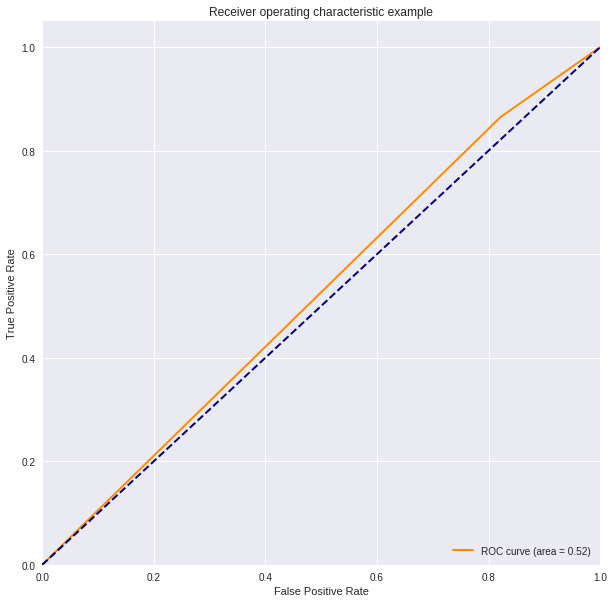

In [0]:
featMatTest_ds = df_to_dataset(featMatTest, shuffle=False, batch_size=(featMatTest.shape[0]))
y_pred11 = model11.predict_proba(featMatTest_ds, batch_size=None)
makeROCCurve(np.array(featMatTest['TARGET']), y_pred11)

It actually performs significantly worse, indicating that more data is better for discrimination between the classes